In [150]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev,opt_prob_metrics_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from scipy.stats import rankdata

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
def sort_models(df: pd.DataFrame):
    x = df[
        ["dev_p_F1score", "dev_s_F1score"]
    ].values.copy()  # ,"dev_p_modified_MAE","dev_s_modified_MAE"
    # x[:, 2:] = 1 / x[:, 2:]
    x /= np.nanmax(x, axis=0, keepdims=True)
    means = np.mean(x, axis=1)
    # print(means)
    if np.isnan(means).all():
        return None
    df["scores"] = means
    df.sort_values(by=["scores"], ascending=False, ignore_index=True, inplace=True)


def rank_models(df: pd.DataFrame):
    x = df[
        ["dev_p_F1score", "dev_s_F1score", "dev_p_modified_MAE2", "dev_s_modified_MAE2"]
    ].values.copy()  # ,"dev_p_modified_MAE","dev_s_modified_MAE"
    x[:, :2] = rankdata(x[:, :2], axis=0)
    x[:, 2:] = rankdata(-x[:, 2:], axis=0)
    # x[:, 2:] = 1 / x[:, 2:]
    # x /= np.nanmax(x, axis=0, keepdims=True)
    means = np.mean(x, axis=1)
    # print(means)
    if np.isnan(means).all():
        return None
    df["average_rank"] = means
    df[["p_f1_rank", "s_f1_rank", "p_mae_rank", "s_mae_rank"]] = x
    # df.sort_values(by=["scores"],ascending=False, ignore_index=True, inplace=True)


def generate_metadata(row):
    meta = {
        "docstring": "Model trained on volcanic earthquakes with a learning rate of LR. The data split is data SPLIT for training/validation/testing.\n"
        "Threshold selected for optimal F1 score on the validation set. Depending on the target region, the thresholds might need to be adjusted.\nWhen using this model, please reference\n\nYiyuan Zhong and Yen Joe Tan (2024). Deep-learning-based phase picking for volcano seismicity, submitted.",
        "model_args": {
            "component_order": "ZNE",
        },
        "seisbench_requirement": "0.4.0",
        "version": "1",
    }
    default_args = {}
    if "lr" in row:
        meta["docstring"] = meta["docstring"].replace("LR", str(row["lr"]))
    else:
        meta["docstring"] = meta["docstring"].replace(" with a learning rate of LR", "")
    if "split" in row:
        meta["docstring"] = meta["docstring"].replace("SPLIT", str(row["split"]))
    else:
        meta["docstring"] = meta["docstring"].replace(
            " The data split is data SPLIT for training/validation/testing.",
            "",
        )
    # meta["docstring"] = meta["docstring"].replace("MAXEPOCH", str(row["max_epoch"]))
    if row["model"] == "eqtransformer":
        if "det_threshold" in row:
            det_threshold = row["det_threshold"]
            if np.isnan(det_threshold):
                det_threshold = (
                    0.3  # Roughly the average detection threshold across datasets
                )
        else:
            det_threshold = (
                0.3  # Roughly the average detection threshold across datasets
            )

        default_args["detection_threshold"] = det_threshold
    elif row["model"] == "phasenet":
        meta["model_args"]["phases"] = "PSN"
    else:
        raise ValueError("Unknown model type")
    default_args["P_threshold"] = float(
        f"{row['p_opt_prob_thre']:.3f}"
    )  # to avoid precision loss in the output, e.g. 0.22 becoming 0.2199999999
    default_args["S_threshold"] = float(f"{row['s_opt_prob_thre']:.3f}")

    meta["model_args"]["norm"] = "peak"
    meta["default_args"] = default_args
    return meta


def export_model(
    row,
    models_path,
    output_base=Path("seisbench_models"),
    filename="volpick",
    version_str="1",
    to_cpu=False,
):
    weights = Path(models_path) / row["exp_name"]
    version = sorted(list(weights.iterdir()), key=lambda x: int(x.name.split("_")[1]))[
        -1
    ]
    config_path = version / "hparams.yaml"
    with open(config_path, "r") as f:
        config = yaml.full_load(f)

    model_cls = models.__getattribute__(config["model"] + "Lit")
    lightning_model = load_best_model(model_cls, weights, version.name)
    output_base = Path(output_base)
    output_path = output_base / row["model"] / f"{filename}.pt.v{version_str}"
    json_path = output_base / row["model"] / f"{filename}.json.v{version_str}"
    output_path.parent.mkdir(parents=True, exist_ok=True)
    if to_cpu:
        print("Move model to cpu")
        lightning_model.model.to(torch.device("cpu"))
    torch.save(lightning_model.model.state_dict(), output_path)

    meta = generate_metadata(row)
    with open(json_path, "w") as f:
        json.dump(meta, f, indent=4)

# Data (7% validation)

In [11]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/VCSEIS2")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["dev", "test"]), inplace=True)
dataset.preload_waveforms(pbar=True)
dataset_lp_and_noise = dataset.filter(
    (dataset.metadata["source_type"] == "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_rg_and_noise = dataset.filter(
    (dataset.metadata["source_type"] != "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
print("Number of traces in the test set and the development set:")
print(f"{len(dataset_lp_and_noise)} lp and noise traces")
print(f"{len(dataset_rg_and_noise)} vt and noise traces")

print(f"""{len(dataset.metadata[dataset.metadata["source_type"]=="lp"])} lp traces""")
print(
    f"""{len(dataset.metadata[(dataset.metadata["source_type"]!="lp")&(dataset.metadata["source_type"]!="noise")])} regular earthquake traces"""
)
print(
    f"""{len(dataset.metadata[dataset.metadata["source_type"]=="noise"])} noise earthquake traces"""
)

Preloading waveforms: 100%|██████████| 23928/23928 [02:09<00:00, 184.42it/s] 

Number of traces in the test set and the development set:
13909 lp and noise traces
13090 vt and noise traces
10838 lp traces
10019 regular earthquake traces
3071 noise earthquake traces


# Models

True
Min val_loss: 361, 0.042899839580059
Min train_loss: 384.0, 0.0395065769553184
/home/zhongyiyuan/volpick/model_training/weights_wholedataset/p/version_0
True
Min val_loss: 474, 0.0157630927860736
Min train_loss: 439.0, 0.0159351639449596
/home/zhongyiyuan/volpick/model_training/weights_wholedataset/e/version_0


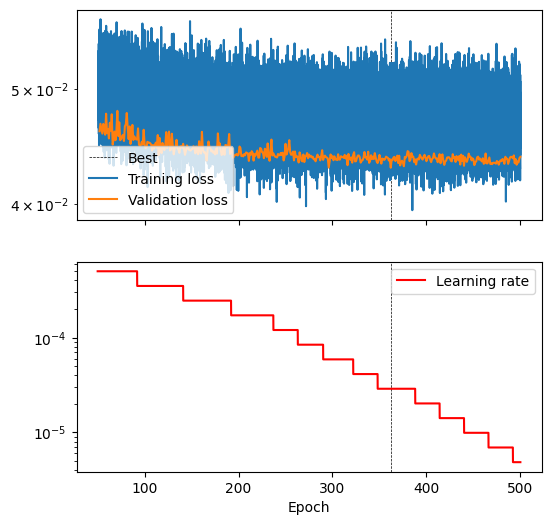

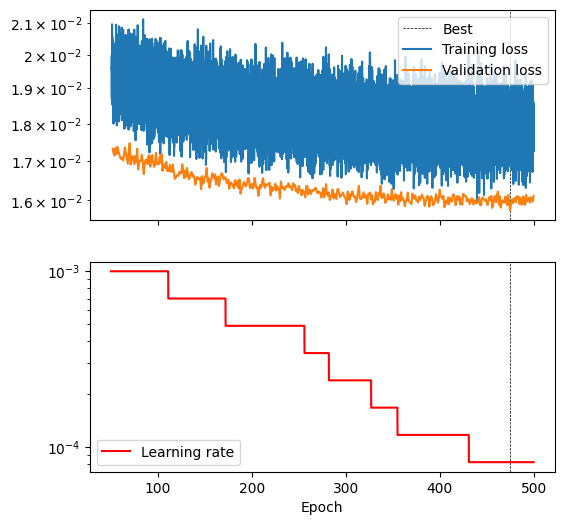

In [93]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights_wholedataset")
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs

for model_dirname in model_dirs:
    model_path = models_root_path / model_dirname
    pl_model = load_best_model_from_base_dir(
        model_path, last=False, plot_step=True, start_epoch_plot=50
    )

True
Min val_loss: 292, 0.0420240610837936
Min train_loss: 394.0, 0.040949922055006
/home/zhongyiyuan/volpick/model_training/weights/p_512_5e-04_ga20_400_s/version_0
True
Min val_loss: 331, 0.0157418083399534
Min train_loss: 336.0, 0.0171123053878545
/home/zhongyiyuan/volpick/model_training/weights/e_1024_1e-03_ga20_400_s_preinstance/version_0


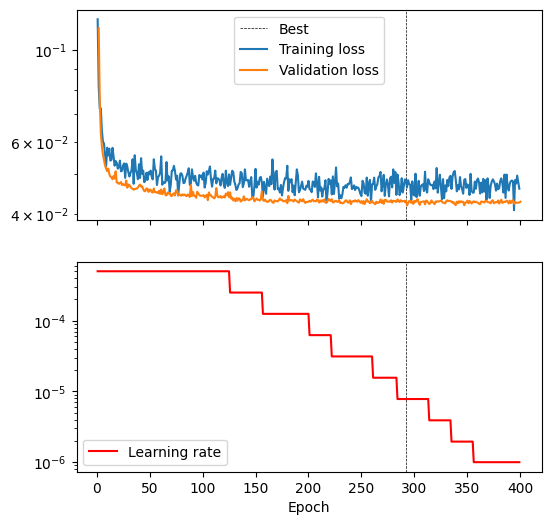

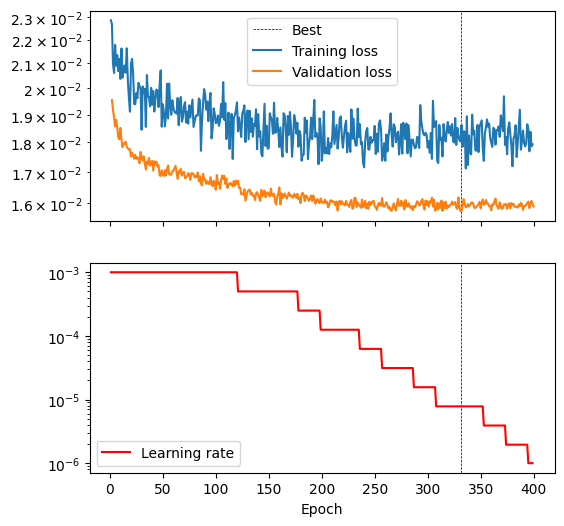

In [64]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights")
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
# model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs = ["p_512_5e-04_ga20_400_s", "e_1024_1e-03_ga20_400_s_preinstance"]

for model_dirname in model_dirs:
    model_path = models_root_path / model_dirname
    pl_model = load_best_model_from_base_dir(
        model_path,
        # ema=True,
        # plot_val_loss=False,
        # version=0,
        # last=True,
        # monitor="train_loss"
        start_epoch_plot=0,
    )

# Validation set

In [132]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/VCSEIS_whole_train")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)

In [101]:
dataset.filter(dataset["split"].isin(["dev"]), inplace=True)
dataset.preload_waveforms(pbar=True)
dataset_lp_and_noise = dataset.filter(
    (dataset.metadata["source_type"] == "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_rg_and_noise = dataset.filter(
    (dataset.metadata["source_type"] != "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
print("Number of traces in the test set and the development set:")
print(f"{len(dataset_lp_and_noise)} lp and noise traces")
print(f"{len(dataset_rg_and_noise)} vt and noise traces")

print(f"""{len(dataset.metadata[dataset.metadata["source_type"]=="lp"])} lp traces""")
print(
    f"""{len(dataset.metadata[(dataset.metadata["source_type"]!="lp")&(dataset.metadata["source_type"]!="noise")])} regular earthquake traces"""
)
print(
    f"""{len(dataset.metadata[dataset.metadata["source_type"]=="noise"])} noise earthquake traces"""
)

Preloading waveforms: 100%|██████████| 18624/18624 [00:40<00:00, 457.42it/s] 


Number of traces in the test set and the development set:
10701 lp and noise traces
10477 vt and noise traces
8147 lp traces
7923 regular earthquake traces
2554 noise earthquake traces


In [102]:
# full data set
targets_path_lp_and_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_whole_train/all"
)
try:
    targets_path_lp_and_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg} exists")

# LP and noise
targets_path_lp = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_whole_train/lp_and_noise"
)
try:
    targets_path_lp.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp} exists")

# VT and noise
targets_path_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_whole_train/rg_and_noise"
)
try:
    targets_path_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg} exists")

In [103]:
replace_if_exist = False
generate_task0(
    dataset=dataset,
    output=targets_path_lp_and_rg,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

100%|██████████| 18624/18624 [00:06<00:00, 2843.81it/s]


## Threshold

In [107]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights_wholedataset")
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs

['p', 'e']

True
Min val_loss: 361, 0.042899839580059
Min train_loss: 384.0, 0.0395065769553184
/home/zhongyiyuan/volpick/model_training/weights_wholedataset/p/version_0
/home/zhongyiyuan/volpick/model_training/Eval_wholetrain/all_pred/task0/p exists
Starting set: dev


Preloading waveforms: 100%|██████████| 18624/18624 [00:00<00:00, 340835.47it/s]

Number of examples in dev: 18624
16070 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100

True
Min val_loss: 474, 0.0157630927860736
Min train_loss: 439.0, 0.0159351639449596
/home/zhongyiyuan/volpick/model_training/wei

Preloading waveforms: 100%|██████████| 18624/18624 [00:00<00:00, 344040.40it/s]

Number of examples in dev: 18624
16070 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100



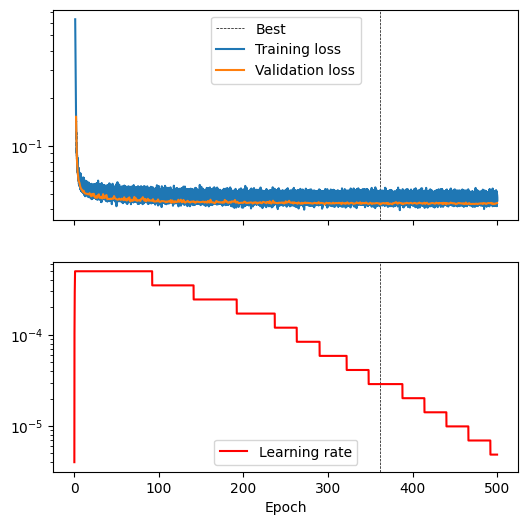

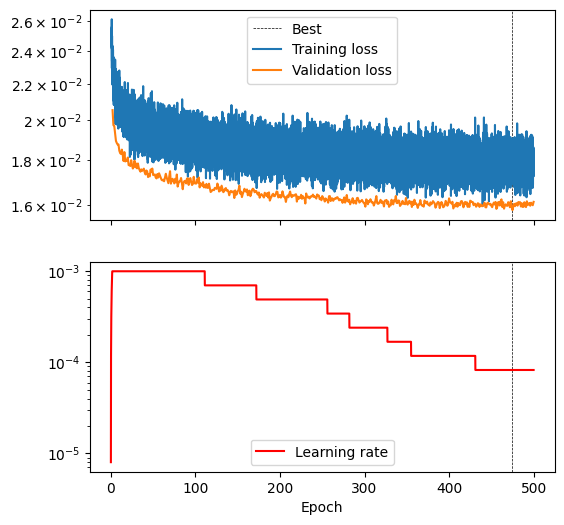

In [108]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg]
dataset_list = [dataset]

for model_dirname in model_dirs:
    model_path = models_root_path / model_dirname
    pl_model = load_best_model_from_base_dir(model_path, plot_loss=True, plot_step=True)
    model = pl_model.model
    for target_i, dataset_i in zip(target_path_list, dataset_list):
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"{model_path.name}",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_wholetrain",
            # prob_thres=np.array([0.27,0.3,0.32]),
            # prob_thres=np.array([0.13,0.15,0.17,0.20,0.22,0.23,0.24,0.25,0.26,0.27,0.3,0.32,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
            prob_thres=np.arange(0.12, 0.42, 0.01),
            num_workers=32,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["dev"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

In [163]:
root_save_dir = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_wholetrain/all_pred/task0"
)
stats_list = []
for pred_dir in [x for x in root_save_dir.iterdir() if x.is_dir()]:
    if pred_dir.is_dir():
        print(pred_dir)
        stats = opt_prob_metrics_dev(pred_dir)
        if pred_dir.name == "p":
            stats["model"] = "phasenet"
            stats["lr"] = 0.0005
        elif pred_dir.name == "e":
            stats["model"] = "eqtransformer"
            stats["lr"] = 0.001
        stats["split"] = "94.5%/5.5%/0"
        stats_list.append(stats)
df = pd.DataFrame(stats_list)

/home/zhongyiyuan/volpick/model_training/Eval_wholetrain/all_pred/task0/p
/home/zhongyiyuan/volpick/model_training/Eval_wholetrain/all_pred/task0/e


In [164]:
df

,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2,model,lr,split
0,p,0.5,0.39,0.32,14515.0,1152.0,1555.0,0.926470,0.903236,0.914705,...,0.06,0.000929,0.00,0.199430,0.199426,0.116265,0.06,phasenet,0.0005,94.5%/5.5%/0
1,e,0.5,0.26,0.23,14810.0,1115.0,1260.0,0.929984,0.921593,0.925770,...,0.07,0.025182,0.02,0.196119,0.197722,0.123619,0.07,eqtransformer,0.0010,94.5%/5.5%/0


In [165]:
"p_opt_prob_thre" in df.iloc[0]

True

In [166]:
df.to_csv(
    Path(
        "/home/zhongyiyuan/volpick/model_training/Eval_wholetrain/all_pred/task0/task0_metrics.csv"
    ),
    index=False,
)

In [167]:
export_model(
    df.iloc[0],
    models_path="/home/zhongyiyuan/volpick/model_training/weights_wholedataset",
    output_base="/home/zhongyiyuan/DATA/seisbench_data/models/v3",
    filename="volpick_95train",
    to_cpu=True,
)

Move model to cpu


In [168]:
export_model(
    df.iloc[1],
    models_path="/home/zhongyiyuan/volpick/model_training/weights_wholedataset",
    output_base="/home/zhongyiyuan/DATA/seisbench_data/models/v3",
    filename="volpick_95train",
    to_cpu=True,
)

Move model to cpu


the original validataion set

In [169]:
data_path2 = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset2 = sbd.WaveformDataset(
    data_path2,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)

In [170]:
dataset2.filter(
    dataset2["split"].isin(
        [
            "dev",
        ]
    ),
    inplace=True,
)
dataset2.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 17744/17744 [00:02<00:00, 6217.28it/s]


In [172]:
targets_path_lp_and_rg2 = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/all"
)
try:
    targets_path_lp_and_rg2.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg2} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/all exists


In [173]:
models_root_path

PosixPath('/home/zhongyiyuan/volpick/model_training/weights_wholedataset')

In [181]:
targets_path_lp_and_rg

PosixPath('/home/zhongyiyuan/volpick/model_training/Eval_targets_whole_train/all')

True
Min val_loss: 361, 0.042899839580059
Min train_loss: 384.0, 0.0395065769553184
/home/zhongyiyuan/volpick/model_training/weights_wholedataset/p/version_0
/home/zhongyiyuan/volpick/model_training/Eval_wholetrain_org_valset/all_pred/task0/p exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 351342.04it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100

True
Min val_loss: 474, 0.0157630927860736
Min train_loss: 439.0, 0.0159351639449596
/home/zhongyiyuan/volpick/model_training/wei

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 346779.47it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100



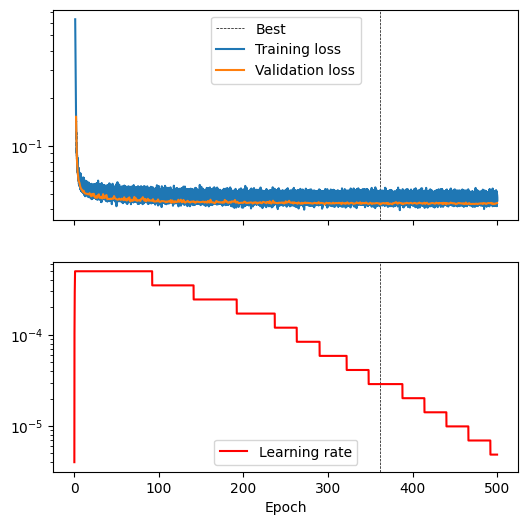

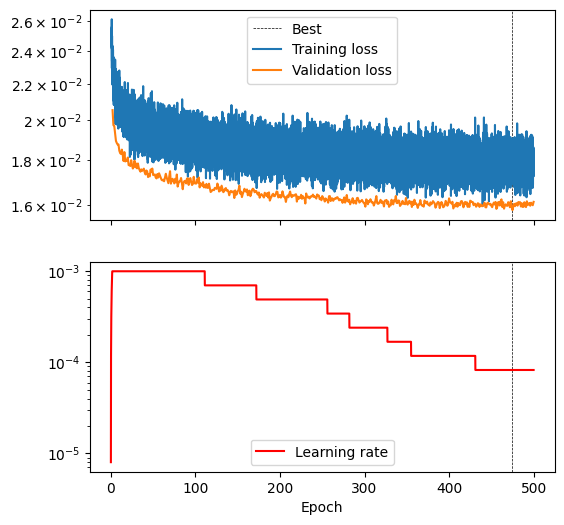

In [182]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg2]
dataset_list = [dataset2]

for model_dirname in model_dirs:
    model_path = models_root_path / model_dirname
    pl_model = load_best_model_from_base_dir(model_path, plot_loss=True, plot_step=True)
    model = pl_model.model
    for target_i, dataset_i in zip(target_path_list, dataset_list):
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"{model_path.name}",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_wholetrain_org_valset",
            # prob_thres=np.array([0.27,0.3,0.32]),
            # prob_thres=np.array([0.13,0.15,0.17,0.20,0.22,0.23,0.24,0.25,0.26,0.27,0.3,0.32,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
            prob_thres=np.arange(0.12, 0.42, 0.01),
            num_workers=32,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["dev"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

In [183]:
root_save_dir = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_wholetrain_org_valset/all_pred/task0"
)
stats_list = []
for pred_dir in [x for x in root_save_dir.iterdir() if x.is_dir()]:
    if pred_dir.is_dir():
        print(pred_dir)
        stats = opt_prob_metrics_dev(pred_dir)
        if pred_dir.name == "p":
            stats["model"] = "phasenet"
            stats["lr"] = 0.0005
        elif pred_dir.name == "e":
            stats["model"] = "eqtransformer"
            stats["lr"] = 0.001
        stats["split"] = "83.6%/5.5%/10.9%"
        stats_list.append(stats)
df2 = pd.DataFrame(stats_list)

/home/zhongyiyuan/volpick/model_training/Eval_wholetrain_org_valset/all_pred/task0/p
/home/zhongyiyuan/volpick/model_training/Eval_wholetrain_org_valset/all_pred/task0/e


In [184]:
df2

,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2,model,lr,split
0,p,0.5,0.32,0.34,13984.0,1297.0,1206.0,0.915123,0.920606,0.917856,...,0.06,0.002581,0.00,0.196198,0.196208,0.114997,0.06,phasenet,0.0005,83.6%/5.5%/10.9%
1,e,0.5,0.26,0.19,14057.0,1019.0,1133.0,0.932409,0.925411,0.928897,...,0.08,0.025356,0.02,0.196240,0.197865,0.124595,0.07,eqtransformer,0.0010,83.6%/5.5%/10.9%


In [186]:
df[["exp_name", "p_opt_prob_thre", "s_opt_prob_thre", "dev_p_F1score", "dev_s_F1score"]]

,exp_name,p_opt_prob_thre,s_opt_prob_thre,dev_p_F1score,dev_s_F1score
0,p,0.39,0.32,0.914705,0.881399
1,e,0.26,0.23,0.925770,0.891961


In [185]:
df2[
    ["exp_name", "p_opt_prob_thre", "s_opt_prob_thre", "dev_p_F1score", "dev_s_F1score"]
]

,exp_name,p_opt_prob_thre,s_opt_prob_thre,dev_p_F1score,dev_s_F1score
0,p,0.32,0.34,0.917856,0.885878
1,e,0.26,0.19,0.928897,0.892596


In [187]:
df.to_csv(
    Path("./Eval_wholetrain_org_valset/all_pred/task0/task0_metrics.csv"),
    index=False,
)